<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500000 entries, 2010-01-01 to 2017-07-28
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          500000 non-null  object 
 1   Country         500000 non-null  object 
 2   Item Type       500000 non-null  object 
 3   Sales Channel   500000 non-null  object 
 4   Order Priority  500000 non-null  object 
 5   Order ID        500000 non-null  int64  
 6   Ship Date       500000 non-null  object 
 7   Units Sold      500000 non-null  int64  
 8   Unit Price      500000 non-null  float64
 9   Unit Cost       500000 non-null  float64
 10  Total Revenue   500000 non-null  float64
 11  Total Cost      500000 non-null  float64
 12  Total Profit    500000 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 53.4+ MB
None
                                       Region      Country   Item Type  \
Order Date                               

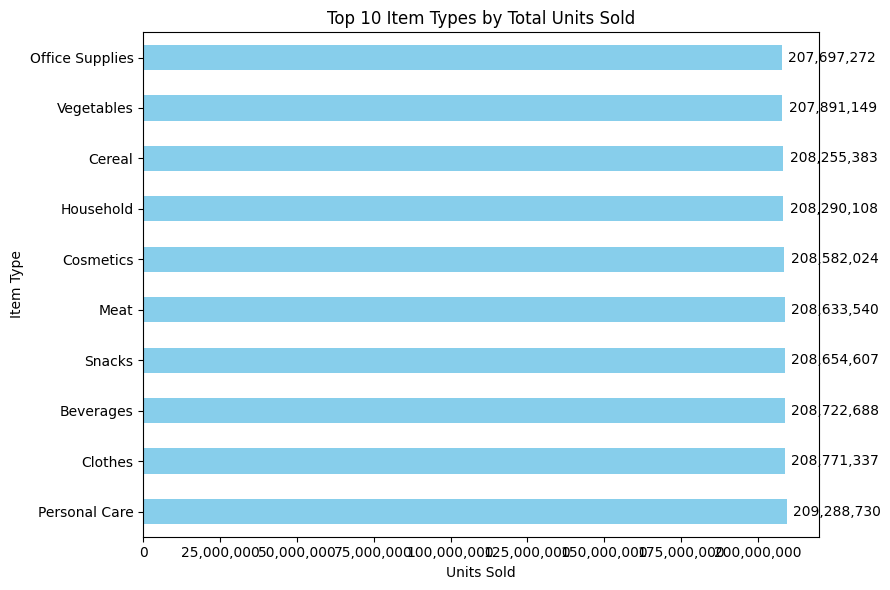

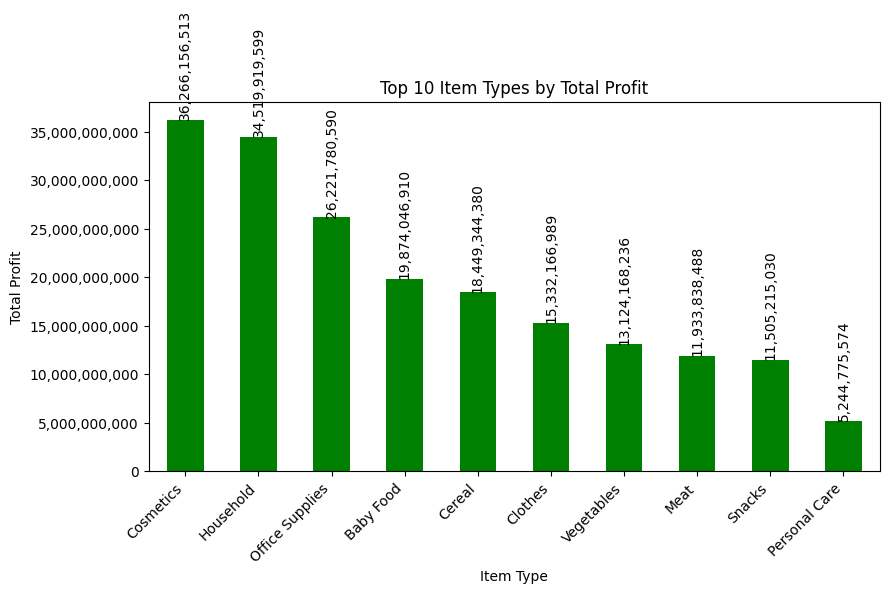

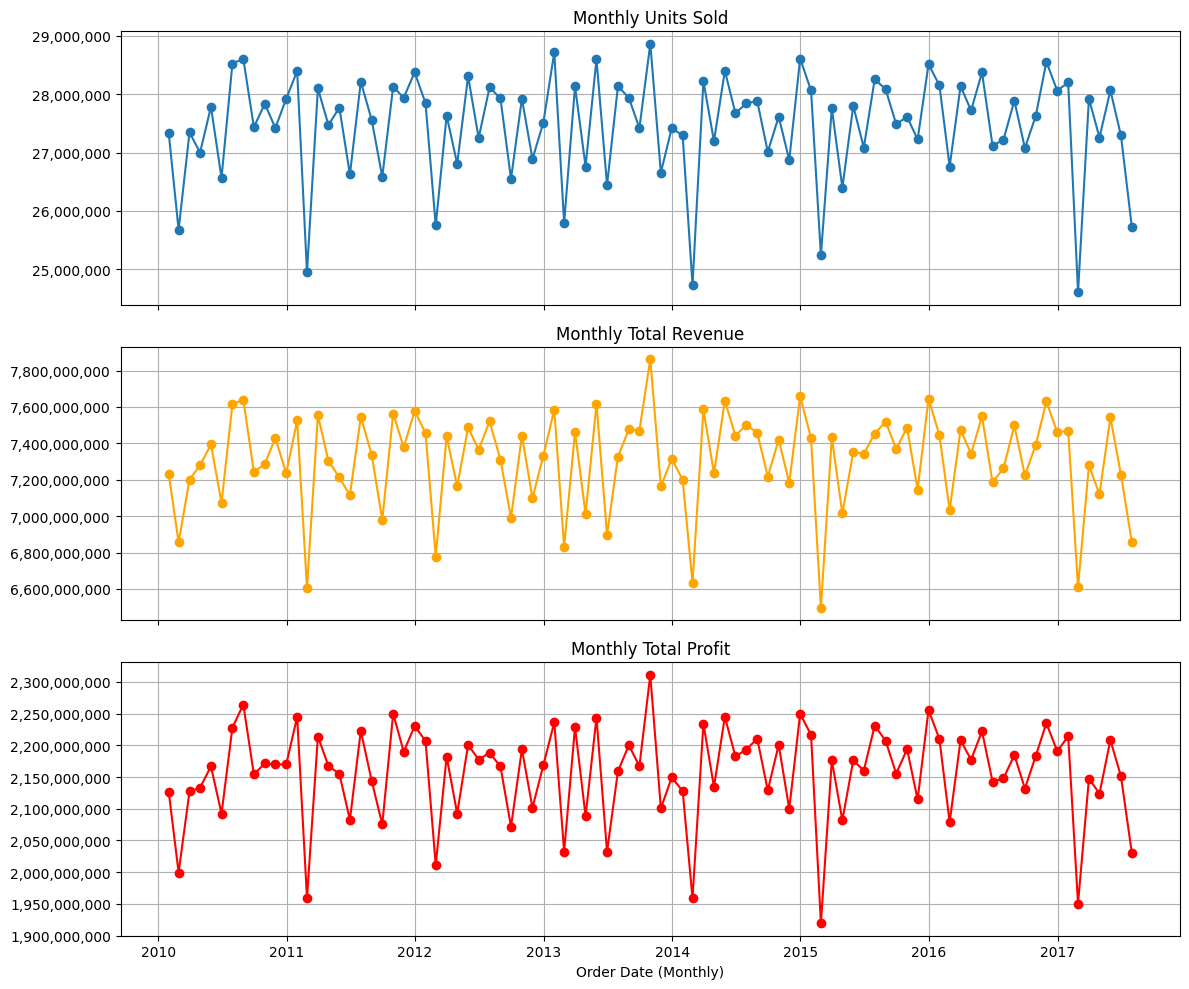

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ----- 1. Load and Clean the Data -----

df = pd.read_csv("arima_sales.csv")

# Convert 'Order Date' to datetime, sort, and set as index
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df.sort_values('Order Date', inplace=True)
df.set_index('Order Date', inplace=True)

print(df.info())
print(df.head())

# ----- 2. Top 10 Item Types by Total Units Sold (Horizontal Bar) -----

# Group by item type and sum units sold
top_units = (
    df.groupby("Item Type")['Units Sold']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(9, 6))
top_units.plot(kind='barh', color='skyblue', ax=ax)

ax.set_title("Top 10 Item Types by Total Units Sold")
ax.set_xlabel("Units Sold")
ax.set_ylabel("Item Type")

# Format the x-axis to avoid scientific notation
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Annotate bars with numeric values
for patch in ax.patches:
    value = patch.get_width()
    ax.annotate(
        f'{value:,.0f}',  # comma formatting
        (value + (0.01 * value), patch.get_y() + 0.5 * patch.get_height()),
        va='center'
    )

plt.tight_layout()
plt.show()

# ----- 3. Top 10 Item Types by Total Profit (Vertical Bar) -----

top_profit = (
    df.groupby("Item Type")['Total Profit']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

fig, ax = plt.subplots(figsize=(9, 6))
top_profit.plot(kind='bar', color='green', ax=ax)

ax.set_title("Top 10 Item Types by Total Profit")
ax.set_xlabel("Item Type")
ax.set_ylabel("Total Profit")

# Format the y-axis
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Annotate bars with numeric values
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(
        f'{height:,.0f}',
        (patch.get_x() + patch.get_width() / 2, height),
        ha='center',
        va='bottom',
        rotation=90
    )

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----- 4. Monthly Time Series (Units Sold, Total Revenue, Total Profit) -----

# Resample monthly and sum
df_monthly = df.resample('ME').sum(numeric_only=True)

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# a) Monthly Units Sold
axs[0].plot(df_monthly.index, df_monthly['Units Sold'], marker='o', linestyle='-')
axs[0].set_title("Monthly Units Sold")
axs[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# b) Monthly Total Revenue
axs[1].plot(df_monthly.index, df_monthly['Total Revenue'], color='orange', marker='o', linestyle='-')
axs[1].set_title("Monthly Total Revenue")
axs[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# c) Monthly Total Profit
axs[2].plot(df_monthly.index, df_monthly['Total Profit'], color='red', marker='o', linestyle='-')
axs[2].set_title("Monthly Total Profit")
axs[2].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for ax in axs:
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.grid(True)

axs[2].set_xlabel("Order Date (Monthly)")

plt.tight_layout()
plt.show()



Top 3 products to restock:
Vegetables: Forecast = 2380574.24, ARIMA Order = (2, 0, 2)
Beverages: Forecast = 2363979.16, ARIMA Order = (1, 0, 2)
Personal Care: Forecast = 2340901.80, ARIMA Order = (1, 0, 0)


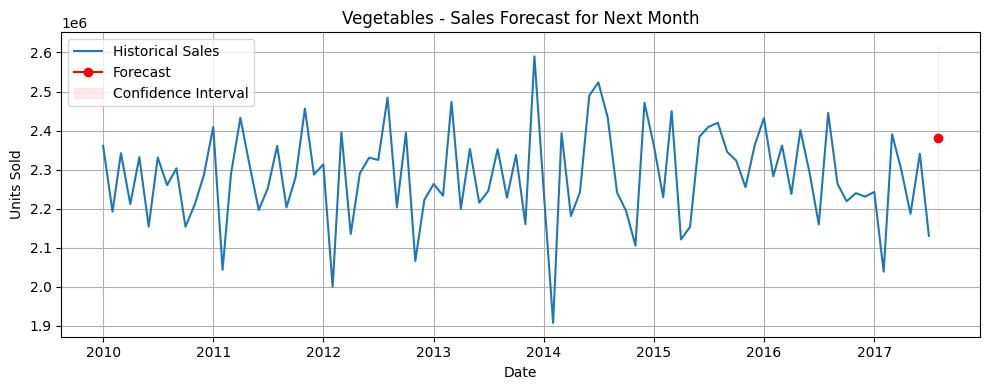

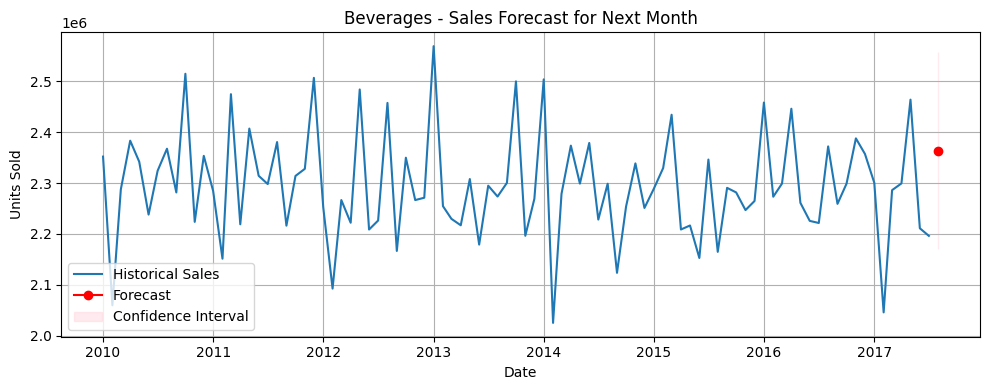

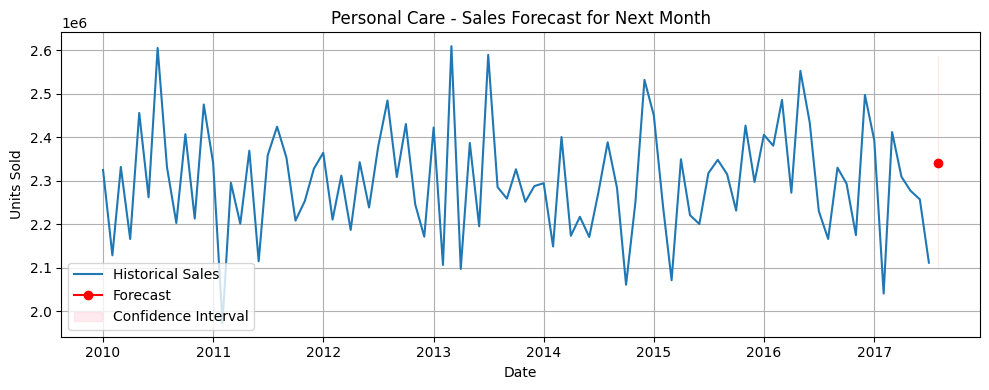

In [10]:
import pandas as pd
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Suppress ARIMA warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


def optimize_arima_order(series, p_range=3, d_range=3, q_range=3):
    """
    Automatically select the best ARIMA order (p,d,q) based on AIC.
    """
    p = d = q = range(0, p_range)
    pdq_combinations = list(itertools.product(p, d, q))

    best_aic = float('inf')
    best_order = None

    for order in pdq_combinations:
        try:
            model = ARIMA(series, order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
        except:
            continue

    return best_order


def forecast_product(series):
    order = optimize_arima_order(series)
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    return forecast.iloc[0], order, model_fit


# Example usage with a dataset:
file_path = "arima_sales.csv"
sales_data = pd.read_csv(file_path)
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])
sales_data['YearMonth'] = sales_data['Order Date'].dt.to_period('M')
monthly_sales = sales_data.groupby(['Item Type', 'YearMonth'])['Units Sold'].sum().unstack(level=0).fillna(0)

# Forecast all items with auto ARIMA
forecasts = {}

for item in monthly_sales.columns:
    forecast, order, model_fit = forecast_product(monthly_sales[item])
    forecasts[item] = {
        'forecast': forecast,
        'order': order,
        'model_fit': model_fit,
        'series': monthly_sales[item]
    }

# Print top 3 by forecast
top_3 = sorted(forecasts.items(), key=lambda x: x[1]['forecast'], reverse=True)[:3]
print("Top 3 products to restock:")
for item, info in top_3:
    print(f"{item}: Forecast = {info['forecast']:.2f}, ARIMA Order = {info['order']}")

# Plotting top 3 forecasts
for item, info in top_3:
    series = info['series']
    model_fit = info['model_fit']
    forecast_result = model_fit.get_forecast(steps=1)
    forecast_value = forecast_result.predicted_mean.iloc[0]
    forecast_date = series.index[-1].to_timestamp() + pd.offsets.MonthBegin()
    conf_int = forecast_result.conf_int()
    lower = conf_int.iloc[0, 0]
    upper = conf_int.iloc[0, 1]

    plt.figure(figsize=(10, 4))
    plt.plot(series.index.to_timestamp(), series, label='Historical Sales')
    plt.plot(forecast_date, forecast_value, marker='o', color='red', label='Forecast')
    plt.fill_between([forecast_date, forecast_date], [lower], [upper], color='pink', alpha=0.3, label='Confidence Interval')
    plt.title(f"{item} - Sales Forecast for Next Month")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Bottom 3 products to consider removing from inventory:
Clothes: Forecast = 2224421.16, ARIMA Order = (2, 0, 2)
Cereal: Forecast = 2225864.62, ARIMA Order = (2, 0, 2)
Fruits: Forecast = 2243693.68, ARIMA Order = (1, 0, 1)


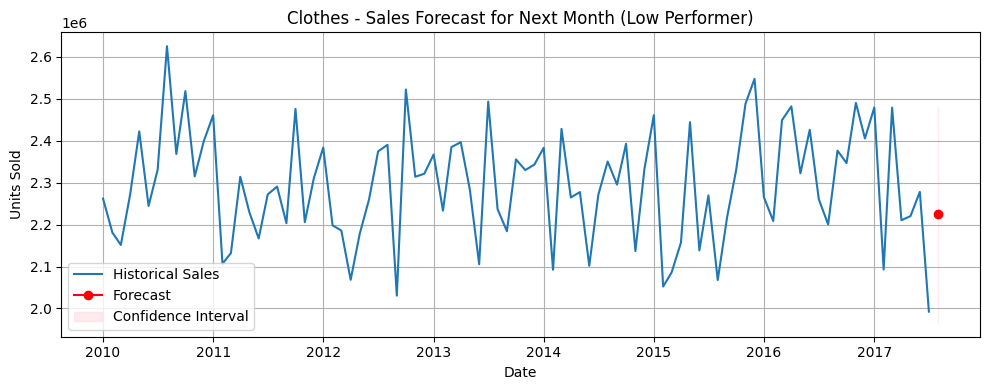

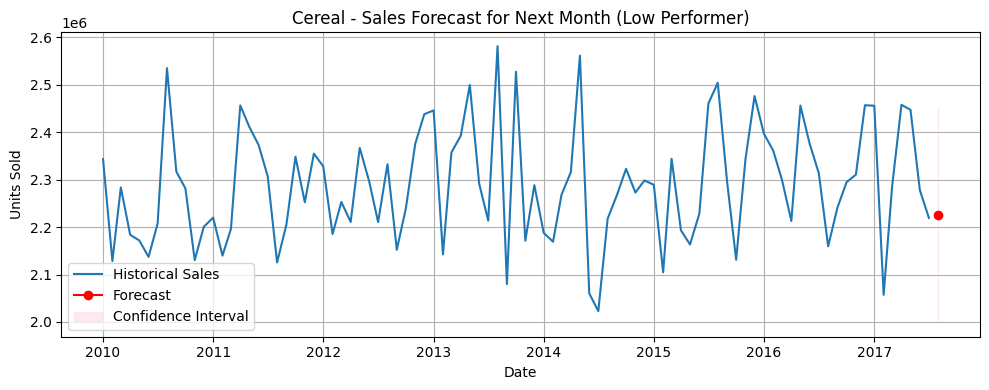

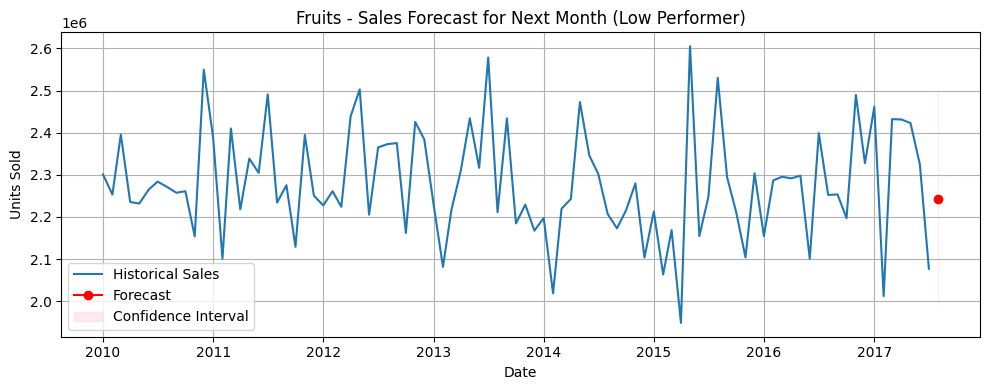

In [11]:
# Suppress ARIMA warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def optimize_arima_order(series, p_range=3, d_range=3, q_range=3):
    """
    Automatically select the best ARIMA order (p,d,q) based on AIC.
    """
    p = d = q = range(0, p_range)
    pdq_combinations = list(itertools.product(p, d, q))

    best_aic = float('inf')
    best_order = None

    for order in pdq_combinations:
        try:
            model = ARIMA(series, order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
        except:
            continue

    return best_order


def forecast_product(series):
    order = optimize_arima_order(series)
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    return forecast.iloc[0], order, model_fit


# Example usage with a dataset:
file_path = "arima_sales.csv"
sales_data = pd.read_csv(file_path)
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])
sales_data['YearMonth'] = sales_data['Order Date'].dt.to_period('M')
monthly_sales = sales_data.groupby(['Item Type', 'YearMonth'])['Units Sold'].sum().unstack(level=0).fillna(0)

# Forecast all items with auto ARIMA
forecasts = {}

for item in monthly_sales.columns:
    forecast, order, model_fit = forecast_product(monthly_sales[item])
    forecasts[item] = {
        'forecast': forecast,
        'order': order,
        'model_fit': model_fit,
        'series': monthly_sales[item]
    }

# Print bottom 3 by forecast
bottom_3 = sorted(forecasts.items(), key=lambda x: x[1]['forecast'])[:3]
print("Bottom 3 products to consider removing from inventory:")
for item, info in bottom_3:
    print(f"{item}: Forecast = {info['forecast']:.2f}, ARIMA Order = {info['order']}")

# Plotting bottom 3 forecasts
for item, info in bottom_3:
    series = info['series']
    model_fit = info['model_fit']
    forecast_result = model_fit.get_forecast(steps=1)
    forecast_value = forecast_result.predicted_mean.iloc[0]
    forecast_date = series.index[-1].to_timestamp() + pd.offsets.MonthBegin()
    conf_int = forecast_result.conf_int()
    lower = conf_int.iloc[0, 0]
    upper = conf_int.iloc[0, 1]

    plt.figure(figsize=(10, 4))
    plt.plot(series.index.to_timestamp(), series, label='Historical Sales')
    plt.plot(forecast_date, forecast_value, marker='o', color='red', label='Forecast')
    plt.fill_between([forecast_date, forecast_date], [lower], [upper], color='pink', alpha=0.3, label='Confidence Interval')
    plt.title(f"{item} - Sales Forecast for Next Month (Low Performer)")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()